In [ ]:
#@title data stuff
import pandas as pd
import datetime
path = '/content/prices/'

df_list = []
names = []
for file_name in os.listdir(path):
  if file_name[0] == '.':
      continue
  name = file_name.split(".")[0]
  df = pd.read_csv(path + file_name)
  df[["Date", name]] = df [['Date', 'Close']]
  df = df[['Date', name]]
  names.append(name)
  df_list.append(df)

dfs = [df.iloc[-1002:-2, :].set_index("Date") for df in df_list if len(df) > 1002]
result = pd.concat(dfs, axis=1, ignore_index=False).bfill().iloc[:-12, :]
differences = result.max() - result.min()
means = result.mean()
relative_variation = differences / means
result_filtered = result.loc[:, relative_variation > 0.1]
result_filtered.to_csv("crypto_2019-11-25_2022-08-20")
crypto_prices = pd.read_csv("/content/crypto_2019-11-25_2022-08-20")
df['Date'] = pd.to_datetime(crypto_prices['Date'])
df = df.sort_values(by='Date')
stock_prices = pd.read_csv("/content/sp500_stocks.csv")
if result_filtered.isnull().any().any():
    print("The dataframe contains NaN values.")
else:
    print("The dataframe does not contain any NaN values.")
import random

df = pd.read_csv('/content/all_stocks_5yr.csv')a
names = df['Name'].unique()
sampled_names = random.sample(list(names), 100)
result_stock = df[["date"]]
for name in sampled_names:
  result_stock = pd.concat((result_stock, df[df["Name"] == name]["close"]) , axis=1, ignore_index=False)#result_stock[name] = df[df["Name"] == name]["close"]
result_stock
import csv
with open('/content/all_stocks_5yr.csv', 'r') as file:
    reader = csv.reader(file)
    data = {}
    next(reader)
    for row in reader:
        date = row[0]
        name = row[6]
        close = row[4]
        if name in data:
            data[name]['closes'].append(close)
        else:
            data[name] = {'closes': [close]}
for name, info in data.items():
    print(f"Name: {name}")
    print(f"Closes: {info['closes']}")
    import pandas as pd
df = pd.read_csv('/content/sp500_stocks.csv')
new_df = df[['Date', 'Symbol', 'Close']]
new_df = new_df.pivot(index='Date', columns='Symbol', values='Close').iloc[-1075:-75,:]

In [1]:
import warnings
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import scipy
from typing import List
#warnings.filterwarnings("ignore")

In [3]:
#@title Import data
closes_crypto = pd.read_csv("/content/crypto_2019-11-25_2022-08-20").iloc[-1000:, 1:].reset_index().drop(columns=["index"])
coins = ["ethereum", "bitcoin", "cardano", "xrp", "dogecoin", "polygon", "IOTA"]
closes_crypto_selection = closes_crypto[coins]
closes_stock = pd.read_csv("/content/sp500_2016-12-22_2022-08-22").iloc[-1000:, 1:].reset_index()

#closes_crypto = remove_outlier(closes_crypto)
#closes_crypto_selection = remove_outlier(closes_crypto_selection)
#closes_stock = remove_outlier(closes_stock)

random_sample = random.sample(list(range(closes_stock.shape[1])), 45)
closes_stock = closes_stock.iloc[:, random_sample]

In [4]:
eta_crypto = returns(closes_crypto)
eta_crypto_selection = returns(closes_crypto_selection)
eta_stock = returns(closes_stock)
print(eta_crypto.isin([np.inf]).any().any())
print(eta_stock.isin([np.inf]).any().any())

False
False


In [2]:
#@title Helper Functions

def remove_outlier(closes:pd.DataFrame) ->  pd.DataFrame:
  q1 = closes.quantile(0.25)
  q3 = closes.quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - (3 * iqr)
  upper_bound = q3 + (3 * iqr)
  closes_filtered = closes[(closes > lower_bound) & (closes < upper_bound)]
  print(f"Number of outliers removed: {closes_filtered.isna().any().sum()}")
  for col in closes_filtered.columns:
      while True:
          nan_count = closes_filtered[col].isna().sum()
          if nan_count == 0:
              # No more NaN values, move on to the next column
              break
          else:
              closes_filtered[col] = closes_filtered[col].fillna(method="bfill").fillna(method="ffill") 
  return closes_filtered


def returns(S:pd.DataFrame) -> pd.DataFrame:
  X = S / S.shift(1).fillna(method="ffill")
  for name, s in X.iteritems():
      X[name].iloc[s.index.get_loc(s.first_valid_index()) -1] = 1.0
  return X-1

def scale_eta(eta: pd.DataFrame) -> pd.DataFrame:
  eta_ = eta.copy()
  scaler = StandardScaler()
  scaler.fit(eta_)
  eta_tilde = scaler.transform(eta_)
  eta_tilde = pd.DataFrame(eta_tilde)
  return eta_tilde

def filter_out_smaller_lambda(eta: pd.DataFrame, lambda_:float) -> pd.DataFrame:
  eta_ = eta.copy().dropna()
  out = eta_[eta_ > lambda_].fillna(0).copy() if lambda_ > 0 else eta_[eta_ < lambda_].fillna(0).copy()
  return out # eta_[eta_ > lambda_].fillna(0).copy()

def filter_indices(indices:pd.Series, column:pd.Series) -> pd.Series:
  return column[column.index.isin(indices)]

# Extreme event correlations

##Correlations conditioned on large market moves

The simplest idea is to measure correlations between stocks conditioned on certain extreme events, for example an extreme market return. It is indeed commonly believed that crosscorrelations between stocks increase in such "high-volatility" periods. Introducing the return of stock $i, \eta_{i}$, and the return of the market $\eta_{m}$ simply defined as the average of all $\eta_{i}$ 's, a natural measure of these correlations is given by the following coefficient:

$$\rho_{>}(\lambda)=\frac{\frac{1}{N^{2}} \sum_{i, j}\left(\left\langle\eta_{i} \eta_{j}\right\rangle_{>\lambda}-\left\langle\eta_{i}\right\rangle_{>\lambda}\left\langle\eta_{j}\right\rangle_{>\lambda}\right)}{\frac{1}{N} \sum_{i}\left(\left\langle\eta_{i}^{2}\right\rangle_{>\lambda}-\left\langle\eta_{i}\right\rangle_{>\lambda}^{2}\right)}$$

where the subscript $>\lambda$ indicates that the averaging is restricted to market returns $\eta_{m}$ in absolute value larger than a certain $\lambda$. For $\lambda=0$ the conditioning disappears. Note that the quantity $\rho_{>}$is the average covariance divided by the average variance, and therefore differs from the average correlation coefficient. The two objects however behave very similarly with $\lambda$, and the theoretical discussion is much easier in terms of $\rho_{>}$.

In a first approximation, the distribution of individual stocks returns can be taken to be symmetrical (see Section 6.3.2), leading $\left\langle\eta_{i}\right\rangle_{>\lambda} \approx 0$. Using the fact that $\eta_{m}=\sum_{i} \eta_{i} / N$, the above equation can be transformed into:

$$\rho_{>}(\lambda) \approx \frac{\sigma_{m}^{2}(\lambda)}{\frac{1}{N} \sum_{i=1}^{N} \sigma_{i}^{2}(\lambda)}$$,

where $\sigma_{m}^{2}(\lambda)$ is the market volatility conditioned to market returns in absolute value larger than $\lambda$, and $\sigma_{i}^{2}(\lambda)=\left\langle r_{i}^{2}\right\rangle_{>\lambda}$.

Now, assume the following decomposition to hold:

$$
\eta_{i}(t)=\beta_{i} \eta_{m}(t)+\epsilon_{i}(t),
$$

where $\beta_{i}$ are fixed, time independent coefficients such that $\sum_{i} \beta_{i} / N=1$, and the $\epsilon_{i}$ are uncorrelated with the market and are the so-called idiosyncratic parts, or residuals. (The onefactor model would correspond to the case where all idiosyncracies are uncorrelated, which we do not need to assume here.) Then one obtains for the average conditional correlation $\rho_{>}(\lambda)$ :

$$\rho_{>}(\lambda)=\frac{\sigma_{m}^{2}(\lambda)}{\left(\frac{1}{N} \sum_{i=1}^{N} \beta_{i}^{2}\right) \sigma_{m}^{2}(\lambda)+\frac{1}{N} \sum_{i=1}^{N} \sigma_{\epsilon_{i}}^{2}}$$.

The quantity $\sigma_{m}^{2}(\lambda)$ is obviously an increasing function of $\lambda$. If the residual volatilities $\sigma_{\epsilon_{i}}^{2}$ are independent of $\eta_{m}$ (and therefore of $\lambda$ ) then the coefficient $\rho_{>}(\lambda)$ is an increasing function of $\lambda$, see Fig. 11.1. 
<img src="https://cdn.mathpix.com/cropped/2022_12_08_1b403185452beeedae75g-03.jpg?height=550&width=800&top_left_y=227&top_left_x=361" width="500"/>


<sub>Fig. 11.1. Correlation measure $\rho_{>}(\lambda)$ conditional to the absolute market return to be larger than $\lambda$, both for the empirical data and the one-factor model. Note that both show a similar apparent increase of correlations with $\lambda$. This effect is actually overestimated by the one-factor model with fixed residual volatilities. $\lambda$ is in percents.<sub>

Equation (11.4) naturally predicts an increase of the correlations (as measured by $\rho_{>}(\lambda)$ ) in high volatility periods. This conclusion is quite general: the very fact of conditioning the correlation on large market returns leads to an increase of the measured correlation, even if the true structure of correlations is strictly time independent. Equation (11.4) actually even overestimates the correlations for large $\lambda$, as shown in Fig. 11.1. This overestimation can be understood qualitatively as a result of neglecting the positive correlation between the amplitude of the market return $\left|r_{m}\right|$ and the residual volatilities $\sigma_{\epsilon_{i}}$, which we discuss in more details in Section 11.2.1 below in terms of the 'variety'. For large values of $\lambda, \sigma_{\epsilon_{i}}$ is indeed found to be larger than its average value. From Eq. (11.4), this effect lowers the correlation $\rho_{>}(\lambda)$ for a given value of $\sigma_{m}^{2}(\lambda)$.

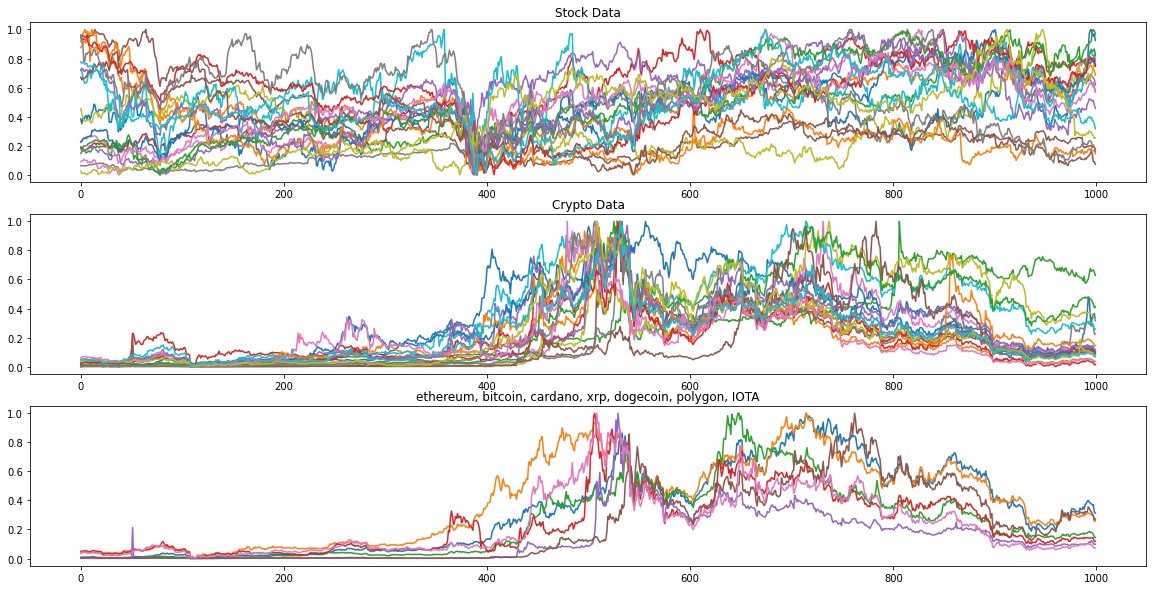

In [5]:
#@title Plot Data
def plot_prices(stock:pd.DataFrame, crypto:pd.DataFrame, crypto2:pd.DataFrame, amount:int, scale:bool=True) -> None:
  random_sample = random.sample(list(range(45)), amount)
  if scale:
    scaler = MinMaxScaler()
    closes_stock = scaler.fit_transform(stock)
    closes_crypto = scaler.fit_transform(crypto)
    closes_crypto2 = scaler.fit_transform(crypto2)
  else:
    closes_stock = stock
    closes_crypto = crypto
    closes_crypto2 = crypto2
  fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
#  for asset in random_sample:
  axes[0].plot(closes_stock[:, random_sample])
  axes[0].title.set_text("Stock Data")
  axes[1].plot(closes_crypto[:, random_sample])
  axes[1].title.set_text("Crypto Data")
  axes[2].plot(closes_crypto2)
  axes[2].title.set_text("ethereum, bitcoin, cardano, xrp, dogecoin, polygon, IOTA")
 
plot_prices(closes_stock, closes_crypto, closes_crypto_selection, 20,scale=True)

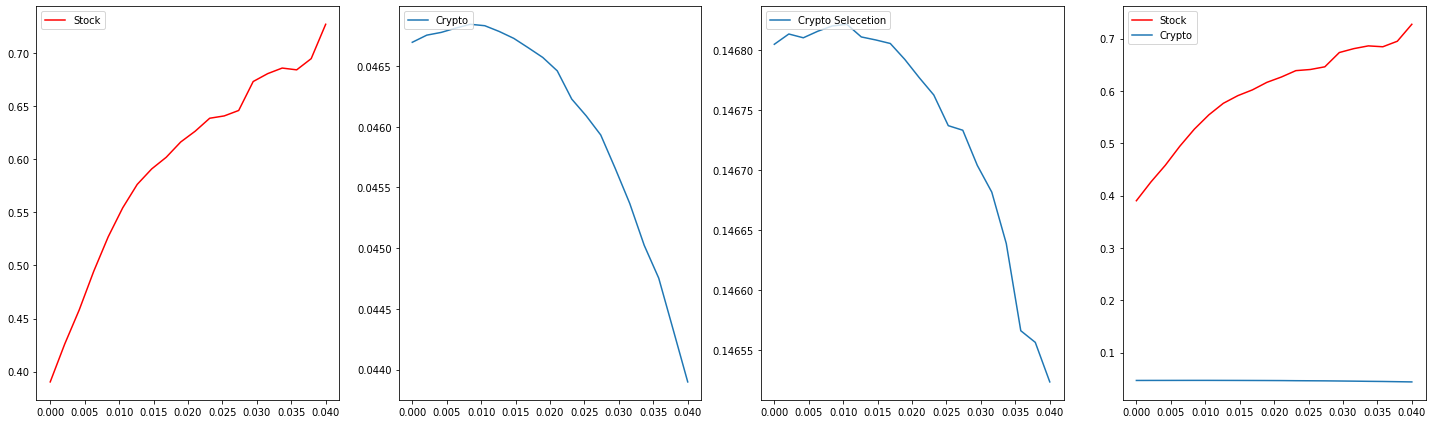

In [7]:
#@title 11.1.1
import matplotlib.ticker as mtick
from itertools import product

def rho_lambda(eta:pd.DataFrame, lambda_:float) -> float:
  eta_m = eta.mean(axis=1)
  indices = eta_m[eta_m.abs() > lambda_].index 
  N = int(eta.shape[1])
  nominator, denominator = 0, 0
  for i, j in product(range(N), range(N)): 
    nominator += np.nan_to_num(filter_indices(indices, eta.iloc[:,i] * eta.iloc[:,j]).mean()) \
     - filter_indices(indices, eta.iloc[:,i]).mean() \
     * filter_indices(indices, eta.iloc[:,j]).mean()
    if j == 0:
      denominator += filter_indices(indices, eta.iloc[:, i] * eta.iloc[:, i]).mean()\
       - (filter_indices(indices, eta.iloc[:, i]).mean())**2
  nominator /= N**2
  denominator /= N
  return nominator/denominator


lambdas = np.linspace(0,0.04,20)
rhos_stock = [rho_lambda(eta_stock, x) for x in lambdas]
rhos_crypto = [rho_lambda(eta_crypto, x) for x in lambdas]
rhos_crypto_selection = [rho_lambda(eta_crypto_selection, x) for x in lambdas]
#plt.figure(figsize=(8, 4), dpi=80)
#plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
#plt.plot(lambdas,  rhos_stock, label="Stock")
#plt.plot(lambdas,  rhos_crypto, label="Crypto")
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
axes[0].plot(lambdas,  rhos_stock, label="Stock", color="r")
axes[0].legend(loc="upper left")
axes[1].plot(lambdas,  rhos_crypto, label="Crypto")
axes[1].legend(loc="upper left")
axes[2].plot(lambdas, rhos_crypto_selection, label="Crypto Selecetion")
axes[2].legend(loc="upper left")
axes[3].plot(lambdas,  rhos_stock, label="Stock", color="r")
axes[3].plot(lambdas,  rhos_crypto, label="Crypto")
axes[3].legend(loc="upper left")
fig.tight_layout()

#plt.legend()
#plt.show()

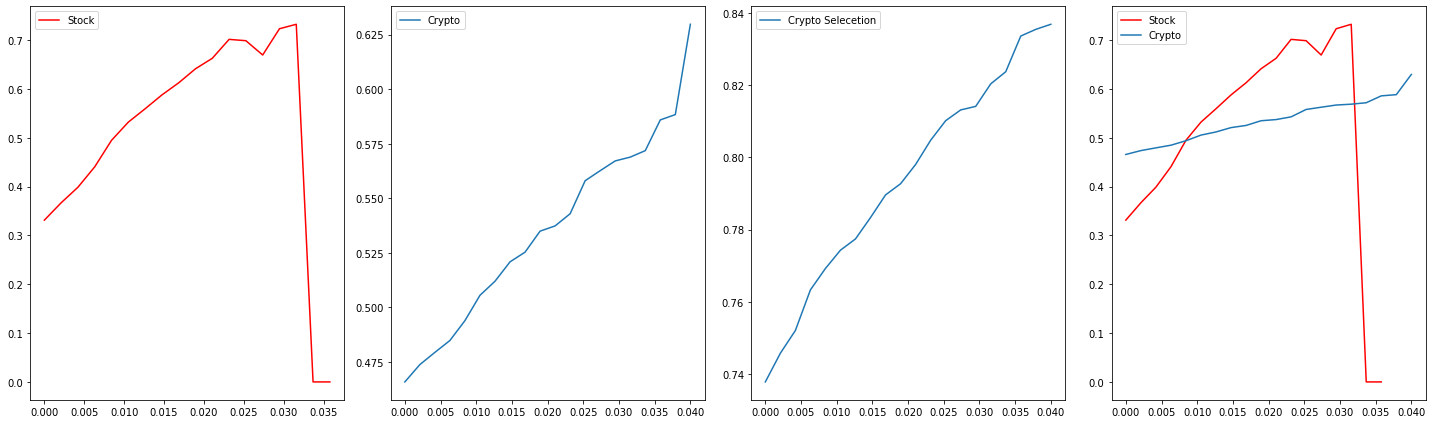

In [9]:
#@title 11.1.1

lambdas = np.linspace(0,0.04,20)
rhos_stock = [rho_lambda(eta_stock.iloc[-300:, :], x) for x in lambdas]
rhos_crypto = [rho_lambda(eta_crypto.iloc[-300:, :], x) for x in lambdas]
rhos_crypto_selection = [rho_lambda(eta_crypto_selection.iloc[-300:, :], x) for x in lambdas]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
axes[0].plot(lambdas,  rhos_stock, label="Stock", color="r")
axes[0].legend(loc="upper left")
axes[1].plot(lambdas,  rhos_crypto, label="Crypto")
axes[1].legend(loc="upper left")
axes[2].plot(lambdas, rhos_crypto_selection, label="Crypto Selecetion")
axes[2].legend(loc="upper left")
axes[3].plot(lambdas,  rhos_stock, label="Stock", color="r")
axes[3].plot(lambdas,  rhos_crypto, label="Crypto")
axes[3].legend(loc="upper left")
fig.tight_layout()


In [10]:
#@title One Factor Model



def get_betas(eta:pd.DataFrame) -> np.array:

  def con(betas:List) -> float:
    return sum(betas)/len(betas) - 1

  cons = {"type": "eq",  "fun": con}
  x0 = np.ones((eta.shape[1],1))
  eta_m = eta.mean(axis=1).to_numpy()
  eta_ = eta.to_numpy()
  
  def error(betas:List) -> float:
    betas = np.expand_dims(betas, axis=1)
    betas_ = np.repeat(betas, repeats=len(eta_m), axis=1).squeeze()
    error = np.absolute((eta_.T - betas_ * eta_m)).sum() 
    return error 

  res = scipy.optimize.minimize(error, x0, method='SLSQP', constraints=cons, options={'disp':True, 'maxiter': 1000})
  return res.x


def get_residuals(eta:pd.DataFrame, betas:np.array) -> pd.DataFrame:
  eta_m = eta.mean(axis=1).to_numpy()
  betas = np.expand_dims(betas, axis=1)
  betas_ = np.repeat(betas, repeats=len(eta_m), axis=1).squeeze()
  eta_ = eta.to_numpy()
  error = ((eta_.T - betas_ * eta_m)).T
  #print((error.T  + betas_ * eta_m).T)
  return pd.DataFrame(error)

betas_stock = get_betas(eta_stock)
eps_stock = get_residuals(eta_stock, betas_stock)
betas_crypto = get_betas(eta_crypto)
eps_crypto = get_residuals(eta_crypto, betas_crypto)
betas_crypto_selection = get_betas(eta_crypto_selection)
eps_crypto_selection = get_residuals(eta_crypto_selection, betas_crypto_selection)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 524.3733027157328
            Iterations: 73
            Function evaluations: 3498
            Gradient evaluations: 73
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1753.3166446614907
            Iterations: 132
            Function evaluations: 7786
            Gradient evaluations: 132
Optimization terminated successfully    (Exit mode 0)
            Current function value: 278.7537438882798
            Iterations: 16
            Function evaluations: 154
            Gradient evaluations: 16


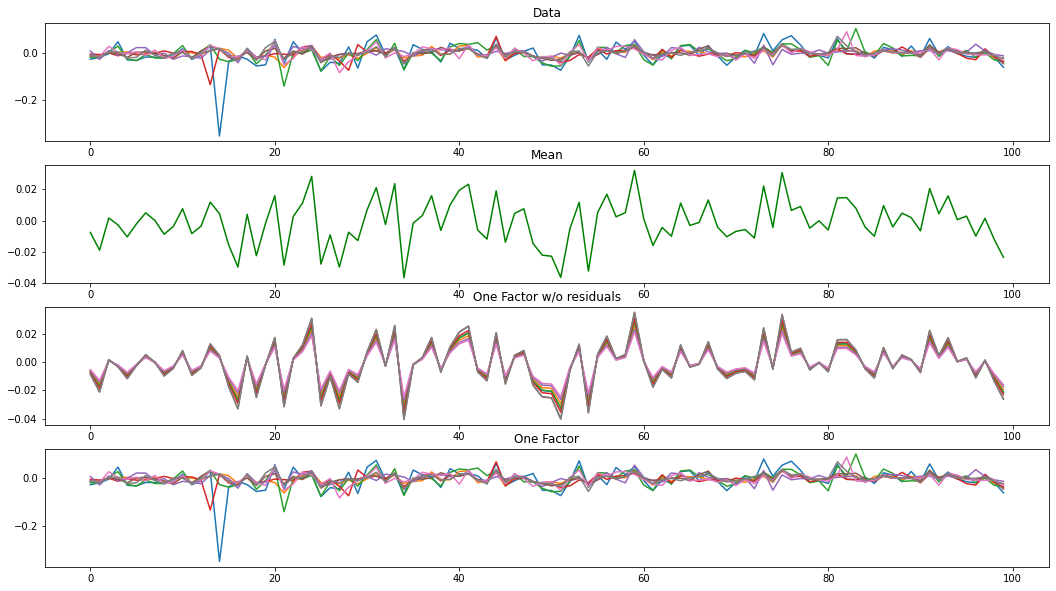

In [30]:
#@title Plot One Factor Model
def plot_one_factor(days:int, eta:pd.DataFrame, betas:np.array, eps:pd.DataFrame, num_assets:int) -> None:
    eta_m = eta.mean(axis=1).to_numpy()
    betas = np.expand_dims(betas, axis=1)
    betas_ = np.repeat(betas, repeats=len(eta_m), axis=1).squeeze()
    eta_ = eta.to_numpy()
    y = betas_ * eta_m
    y= y.T
    y_ = y + eps.values
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18, 10))
    axes[0].plot(eta.values[-days:,-num_assets:], label="Data")
    axes[0].title.set_text("Data")
    axes[1].plot(eta_m[-days:], label="Mean", color="g")
    axes[1].title.set_text("Mean") 
    axes[2].plot(y[-days:,-num_assets:], label="One Factor")
    axes[2].title.set_text("One Factor w/o residuals")
    axes[3].plot(y_[-days:,-num_assets:], label="One Factor")
    axes[3].title.set_text("One Factor")

plot_one_factor(100, eta_stock, betas_stock, eps_stock,  8)

In [41]:
#@title m
def rho_one_factor(lambda_:float, eta:pd.DataFrame, residuals:pd.DataFrame, betas) -> float:
  eta_ = eta.copy()
  eta_m = eta_.mean(axis=1, skipna=True).abs()

  eta_['Absolute Average'] = eta_.mean(axis=1).abs()

  eta_ = eta_[eta_['Absolute Average'] > lambda_]

  sigma_m = eta_['Absolute Average'].std(skipna=True)
  sigma_eps = residuals.std(axis=1, skipna=True )
  N = len(betas)
  nominator = sigma_m**2
  denominator = 1/N *(sum(betas**2)) *sigma_m**2 + 1/N * (sum(sigma_eps**2))
  #print(eta_)
  return nominator / denominator

lambdas = np.linspace(0,0.04,50)
rhos_stock = [rho_one_factor(x, eta_stock, eps_stock, betas_stock) for x in lambdas]
#plt.plot(lambdas, rhos_stock)

#Conditioning on large individual stock returns: exceedance correlations

We now study more specifically how extreme stock returns are correlated between themselves. A first possibility is to study the so-called e**xceedance correlation function**, introduced in Longin \& Solnik (2001). One first defines from the $\eta_{i}$ 's normalized centered returns $\tilde{\eta}_{i}$ with zero mean and unit variance. The positive exceedance correlation between $i$ and $j$ is defined as:

$$\rho_{i j}^{+}(\theta)=\frac{\left\langle\tilde{\eta}_{i} \tilde{\eta}_{j}\right\rangle_{>\theta}-\left\langle\tilde{\eta}_{i}\right\rangle_{>\theta}\left\langle\tilde{\eta}_{j}\right\rangle_{>\theta}}{\sqrt{\left(\left\langle\tilde{\eta}_{i}^{2}\right\rangle_{>\theta}-\left\langle\tilde{\eta}_{i}\right\rangle_{>\theta}^{2}\right)\left(\left|\tilde{\eta}_{j}^{2}\right\rangle_{>\theta}-\left\langle\tilde{\eta}_{j}\right\rangle_{>\theta}^{2}\right)}}$$,

where the subscript $>\theta$ means that both normalized returns $\tilde{\eta}_{i, j}$ are larger than a certain $\theta$. For $\theta \rightarrow-\infty, \rho_{i j}^{+}$becomes the usual correlation coefficient, whereas large positive $\theta$ 's correspond to correlations between extreme positive moves. The negative exceedance correlation $\rho_{i j}^{-}(\theta)$ is defined similarly, the conditioning being now on normalized returns smaller than $\theta$.

Figure $11.2$ shows the exceedance correlation function as a function of $\theta$, when $\tilde{\eta}_{i, j}$ are obtained as the linear combination of two independent random variables $\xi_{1,2}$, such that their correlation coefficient is equal to $\rho=0.5$, but when (a) $\xi_{1,2}$ are Gaussian random variables and (b) $\xi_{1,2}$ are Student variables with a tail index $\mu=4$. Interestingly, the shape of $\rho_{i j}^{\pm}(\theta)$ is completely different in the two cases. For correlated Gaussian variables, $\rho_{i j}^{\pm}(\theta)$ decreases with $|\theta|$; in this sense, extreme events become uncorrelated for Gaussian returns. On the contrary, $\rho_{i j}^{\pm}(\theta)$ increases with $|\theta|$ in the Student case and becomes unity for large $|\theta|$. More generally, the growth of the exceedance correlation with $|\theta|$ is associated to distribution tails fatter than exponential (as for the Student case). 

<img src="https://cdn.mathpix.com/cropped/2022_12_08_1b403185452beeedae75g-05.jpg?height=545&width=800&top_left_y=225&top_left_x=361" width="500"/>

<sub>Fig. 11.2. Exceedance correlation functions for two Gaussian variables (full line) and two Student variables (dotted line). We have shown $\rho_{i j}^{+}(\theta)$ for positive $\theta$ and $\rho_{i j}^{-}(\theta)$ for negative $\theta$. In both cases the correlation coefficient is set to $\rho=0.5$. Note the important difference of shape in the two cases.<sub>

<img src="https://cdn.mathpix.com/cropped/2022_12_08_1b403185452beeedae75g-05.jpg?height=547&width=797&top_left_y=985&top_left_x=365" width="500"/>
<sub>Fig. 11.3. Average exceedance correlation functions between stocks as a function of the level parameter $\theta$, both for real data and the surrogate one-factor model. We have $\operatorname{shown} \rho_{i j}^{+}(\theta)$ for positive $\theta$ and $\rho_{i j}^{-}(\theta)$ for negative $\theta$. Note that this quantity grows with $|\theta|$ and is strongly asymmetric.<sub>

Figure $11.3$ shows the exceedance correlation function, averaged over all the possible pairs of stocks $i$ and $j$, both for real data and for the surrogate one-factor model data. As in other studies, the empirical $\rho^{\pm}(\theta)$ is found to grow with $|\theta|$ and is larger for large negative moves than for large positive moves.

Figure 11.3 however clearly shows that a fixed correlation non Gaussian one-factor model is enough to explain quantitatively the level and asymmetry of the exceedance correlation function, without having to invoke time dependent correlations (such as, for example, 'regime switching' scenarios, see Beckaert \& Wu (2000)). In particular, the asymmetry is entirely induced by the large negative skewness in the distribution of index returns.

<ipython-input-42-029ef75c1657>:21: RuntimeWarning: divide by zero encountered in double_scalars
  rho_ij = nominator / denominator
<ipython-input-42-029ef75c1657>:21: RuntimeWarning: invalid value encountered in double_scalars
  rho_ij = nominator / denominator


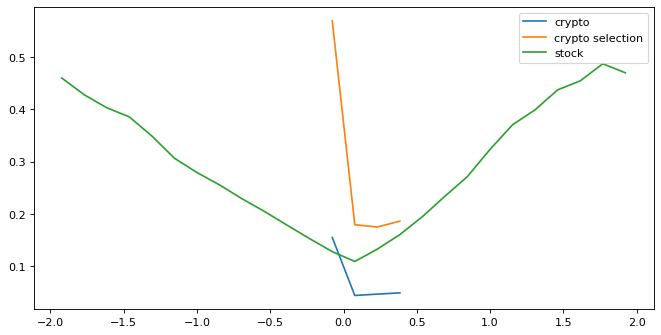

In [42]:
#@title 11.1.3 method 1
eta_tilde_crypto = scale_eta(eta_crypto)
eta_tilde_crypto_selection = scale_eta(eta_crypto_selection)
eta_tilde_stock = scale_eta(eta_stock).iloc[:, :]

def rho(eta_tilde:pd.DataFrame, theta:float) -> float:
  eta_tilde_ = eta_tilde.copy()
  eta_t_theta_na = eta_tilde_[eta_tilde_ < theta] if theta < 0 else eta_tilde_[eta_tilde_ > theta]
  N = int(eta_tilde.shape[1])
  storage = np.zeros((N,N))
  for i, j in product(range(N), range(N)):
    eta_t_i = eta_t_theta_na.iloc[:, i]
    eta_t_j = eta_t_theta_na.iloc[:, j]
    eta_i_avg = eta_t_i.mean(skipna=True)
    eta_j_avg = eta_t_j.mean(skipna=True)
    eta_i_eta_j_avg = (eta_t_i * eta_t_j).mean(skipna=True)
    eta_i_sq_avg = (eta_t_i * eta_t_i).mean(skipna=True)
    eta_j_sq_avg = (eta_t_j * eta_t_j).mean(skipna=True)
    nominator = eta_i_eta_j_avg - eta_i_avg * eta_j_avg
    denominator = math.sqrt((eta_i_sq_avg - eta_i_avg ** 2) * (eta_j_sq_avg - eta_j_avg **2) * N)
    rho_ij = nominator / denominator
    storage[i,j] = rho_ij
  return storage.mean()

def rho2(eta_tilde:pd.DataFrame, theta:float) -> float:
  eta_tilde_ = eta_tilde.copy()
  eta_t_theta = eta_tilde_[eta_tilde_ < theta].fillna(0) if theta > 0 else eta_tilde_[eta_tilde_ > theta].fillna(0)
  rho = eta_t_theta.corr()
  return rho.mean().mean()

theta = np.linspace(-3, 3, 40)
rho_crypto = [rho(eta_tilde_crypto, t) for t in theta]
rho_stock = [rho(eta_tilde_stock, t) for t in theta]
rho_crypto_selection =  [rho(eta_tilde_crypto_selection, t) for t in theta]
plt.figure(figsize=(10, 5), dpi=80)

plt.plot(theta, rho_crypto, label="crypto")
plt.plot(theta, rho_crypto_selection, label="crypto selection")
plt.plot(theta, rho_stock, label="stock")
plt.legend()

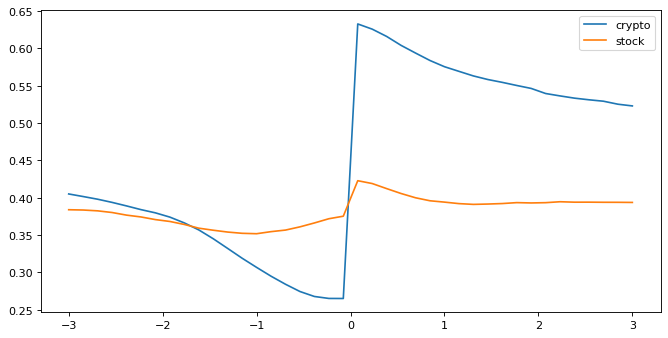

In [43]:
#@title method2
theta = np.linspace(-3, 3, 40)
rho_crypto = [rho2(eta_tilde_crypto, t) for t in theta]
rho_stock = [rho2(eta_tilde_stock, t) for t in theta]
#rho_crypto_selection =  [rho(eta_tilde_crypto_selection, t) for t in theta]
plt.figure(figsize=(10, 5), dpi=80)

plt.plot(theta, rho_crypto, label="crypto")
#plt.plot(theta, rho_crypto_selection, label="crypto selection")
plt.plot(theta, rho_stock, label="stock")
plt.legend()

##Tail dependence

An interesting way to measure the correlation between extreme events is to compute the so-called coefficient of tail dependence, defined as follows. Consider two random variables $\eta_{i}, \eta_{j}$, with marginal distributions $P_{i}\left(\eta_{i}\right), P_{j}\left(\eta_{j}\right)$, and the corresponding cumulative distributions $P_{>, i, j}$. If we choose a certain probability level $p$, one can define the values of $\eta_{i}^{*}, \eta_{j}^{*}$ such that:

$$P_{>, i}\left(\eta_{i}^{*}\right)=P_{>, j}\left(\eta_{j}^{*}\right)=p$$

The coefficient of tail dependence $\rho_{t, i j}^{+}$measures the probability that $\eta_{i}$ exceeds $\eta_{i}^{*}$, conditional to the fact that $\eta_{j}$ itself exceeds $\eta_{j}^{*}$, in the limit of extreme events, i.e. $p \rightarrow 0:^{\dagger}$

$$\rho_{t, i j}^{+}=\lim _{p \rightarrow 0} P\left(\eta_{i}>\eta_{i}^{*} \mid \eta_{j}>\eta_{j}^{*}\right)$$

In other words, $\rho_{t}^{+}$measures the tendency for extreme events to occur simultaneously. As defined, $\rho_{t}^{+}$is between 0 and 1 but appears not to be symmetrical in the permutation of $i$ and $j$. However, the conditional probability is by definition given by:

$$P\left(\eta_{i}>\eta_{i}^{*} \mid \eta_{j}>\eta_{j}^{*}\right)=\frac{P\left(\eta_{i}>\eta_{i}^{*} \wedge \eta_{j}>\eta_{j}^{*}\right)}{P_{>}\left(\eta_{j}^{*}\right)}$$,

and since we have chosen $\eta_{i}^{*}$ and $\eta_{j}^{*}$ such that Eq. (11.8) holds, one sees that $\rho_{t, i j}^{+}$is indeed symmetrical.

If $\eta_{i}$ and $\eta_{j}$ are independent, then $P\left(\eta_{i}>\eta_{i}^{*} \mid \eta_{j}>\eta_{j}^{*}\right)=p$ and therefore $\rho_{t, i j}^{+}=0$. Interestingly, if $\eta_{i}$ and $\eta_{j}$ are correlated Gaussian variables with a correlation coefficient $\rho$ then, unless $\rho=1$, one also has $\rho_{t, i j}^{+}=0$. Note that the coefficient of tail dependence is by construction invariant under any change of variables $\tilde{\eta}_{i}=f_{i}\left(\eta_{i}\right), \tilde{\eta}_{j}=f_{j}\left(\eta_{j}\right)$, which changes the marginal distributions but not $\rho_{t, i j}^{+}$. The coefficient of tail dependence therefore only reflects the correlation structure of the underlying 'copula' (see Section 9.2.3).

More interesting is the case where $\eta_{i}$ and $\eta_{j}$ are obtained as the sum of power-law distributed independent 'factors':

$$\eta_{i}=\sum_{a=1}^{M} v_{a, i} e_{a}$$

where

$$P\left(e_{a}\right) \underset{e_{a} \rightarrow \pm \infty}{\simeq} \frac{\mu A_{a}^{\mu}}{\left|e_{a}\right|^{1+\mu}}$$,

$\dagger$ We define here the coefficient of tail dependence for the right tail. The left tail coefficient $\rho_{t}^{-}$can be defined similarly and is a priori different from $\rho_{t}^{+}$. the $v_{a, i}$ are coefficients. Since power-law variables are (asymptotically) stable under addition, the decomposition Eq. (11.11) leads for all $\mu$ to correlated power-law variables $\eta_{i}$ with, as discussed in Chapter 2 , a tail amplitude given by:

$$A_{i}^{\mu}=\sum_{a=1}^{M}\left|v_{a, i}\right|^{\mu} A_{a}^{\mu}$$

The crucial remark is that for power law variables, $\eta_{i}$ is asymptotically large whenever one of the factor $e_{a}$ is individually large (this property is also useful for the analysis of the risk of complex portfolios, see Section 12.4). The coefficient of tail dependence can then be computed to be:

$$\rho_{t, i j}^{+}=\sum_{a / v_{a, i} v_{a, j}>0} A_{a}^{\mu} \min \left(\frac{\left|v_{a, i}\right|^{\mu}}{\sum_{b}\left|v_{b, i}\right|^{\mu} A_{b}^{\mu}}, \frac{\left|v_{a, j}\right|^{\mu}}{\sum_{b}\left|v_{b, j}\right|^{\mu} A_{b}^{\mu}}\right)$$.

Note that $0 \leq \rho_{t, i j}^{+} \leq 1$ from the above formula. In the simple case of a one-factor model given by Eq. (11.3), where both the market and residual have a power-law distribution and $\beta_{i}>0$, the coefficient of tail dependence between asset $i$ and the market can be computed using the above formula, and reads: ${ }^{\dagger}$

$$\rho_{t, i m}^{\pm}=\frac{\beta_{i}^{\mu} A_{m}^{\mu}}{\beta_{i}^{\mu} A_{m}^{\mu}+A_{\epsilon_{i}}^{\mu}}$$.

As intuitively expected, $\rho_{t, i m}^{\pm}$grows from zero to one as $\beta_{i}$ increases from zero to infinity.

Another case of interest is when the $\eta_{i}, \eta_{j}$ are multivariate Student variables. As explained in Section 9.2.5, one can obtain such variables by first choosing two random Gaussian variables $\xi_{i}, \xi_{j}$, of unit variance and correlation coefficient $\rho$, and multiplying both of them by a common factor $f=\sqrt{\mu / s}$, where $s$ is a positive random variable with a Gamma distribution. The coefficient of tail dependence in this case can be computed, but the final formula is not very helpful. A plot of $\rho_{t, i j}^{+}$as a function of $\rho$ for $\mu=4$ is shown in Fig. 11.4.

On a more practical side, one might wonder whether the tail dependence coefficient and the usual correlation coefficient really grasp different information about a given pair of assets. To say it bluntly: is the tail dependence useful in real life?

To compute an empirical tail dependence, one needs to set a value for $p$. This value should be small since in theory we should let $p$ tend towards zero. On the other hand the smaller the value of $p$, the fewer the events that determine $\rho_{t, i j}^{\pm}$and therefore the more noise in its determination. The relative standard error on $\rho_{t, i j}^{\pm}$is given by $1 / \sqrt{\rho_{t, i j}^{\pm} p N}$, where $N$ is the number of data points (days) used. This is found to be $28 \%$ for the values given below, which is much larger than the relative error on the usual correlation coefficient: $1 / \sqrt{N}$ (2.3\%). Note also that the possible values of $\rho_{t, i j}^{\pm}$are discrete and come in increments of $1 / p N$

We have computed $\rho_{t, i j}^{\pm}$and the standard correlation $\rho_{i j}$ for a set of 388 large cap. US stocks using daily data from Jan. 1993 to June 2000 . Figure $11.5$ shows a scatter plot of $\rho_{t, i j}^{-}$

$\dagger$ This formula was also obtained in Malevergne \& Sornette (2002b). 


<img src="https://cdn.mathpix.com/cropped/2022_12_08_1b403185452beeedae75g-08.jpg?height=552&width=802&top_left_y=226&top_left_x=360" width="500"/>
<sub>Fig. 11.4. Tail dependence coefficient $\rho_{t}^{+}$and tail correlation coefficient $\rho_{t}$ as a function of the correlation coefficient $\rho$ of the two Gaussian variables used to generate a bivariate Student distribution with $\mu=4$. Note that these coefficients are non zero even if $\rho=0$, since the correlation is induced by the strong common 'volatility' factor.<sub>


<img src="https://cdn.mathpix.com/cropped/2022_12_08_1b403185452beeedae75g-08.jpg?height=756&width=802&top_left_y=967&top_left_x=362" width="500"/>
<sub>Fig. 11.5. Scatter plot of $\rho_{t, i j}^{-}$versus the usual correlation $\rho_{i j}$. The empirical $\rho_{t, i j}^{-}$was defined using $p=5 \%$. The dataset consists of $7.5$ years of daily data for 388 US large cap. stocks. The discreteness of $\rho_{t, i j}^{-}$arises from the empirical determination of probabilities, the minimum difference between two values is given by $1 /(0.05 T) \approx 0.01$.<sub>

vs. $\rho_{i j}$. We notice that the two quantities are very correlated $(\rho=76 \%)$ with a fairly linear relationship between them. On our dataset, the average $\rho_{t, i j}^{-}$is $0.154$ while the average $\rho_{i j}$ is $0.168$. Results for $\rho_{t, i j}^{+}$(not shown) were very similar, with a lower average value $(0.123){ }^{\dagger}$

$\dagger$ The difference between $\left\langle\rho_{t}^{+}\right\rangle$and $\left\langle\rho_{t}^{-}\right\rangle$is a manifestation of the large skewness of the market returns. Note however that $\rho_{t, i j}^{-}$never exceeds $0.45$, whereas $\rho_{i j}$ can be as high as $0.7$. Interestingly, from that point of view, extreme events appear less correlated than naively expected.

Are the deviations from the linear relationship seen in Figure 11.5 signal or noise? In other words are the two quantities noisy estimates of the same thing or are they carrying different information? To answer that question one can divide the dataset between odd days and even days and correlate the coefficients obtained on the two non-overlapping datasets. The first finding is that the empirical tail dependences are much more noisy than the standard correlation coefficients. Values for the same pair of stocks from non-overlapping datasets are correlated to a mere $34 \%$ while the standard coefficients have an $80 \%$ correlation. More interestingly the $\rho_{i j}$ 's are correlated at $54 \%$ with the $\rho_{t, i j}^{-}$'s computed on a different dataset, i.e. more than the tail dependence among themselves! This clearly shows that on real data the potential extra information in the tail dependence coefficients is completely obscured by measurement noise.

In [48]:
def tail_dependence(returns: pd.DataFrame) -> float:
    from scipy.stats import kendalltau
    columns = returns.columns
    coefficients = []
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            coefficient = kendalltau(returns[columns[i]], returns[columns[j]])[0]
            coefficients.append(coefficient)
    average = sum(coefficients) / len(coefficients)
    return average
print(f"stock returns correlation: {eta_stock.corr().mean().mean()}")
print(f"stock returns tail dependence: {tail_dependence(eta_stock)}")
print(f"crypto returns correlation: {eta_crypto.corr().mean().mean()}")
print(f"cryptoreturns tail dependence: {tail_dependence(eta_crypto)}")

stock returns correlation: 0.41200961817961407
stock returns tail dependence: 0.24779424196560657
crypto returns correlation: 0.4483534855156744
cryptoreturns tail dependence: 0.3798168820105792


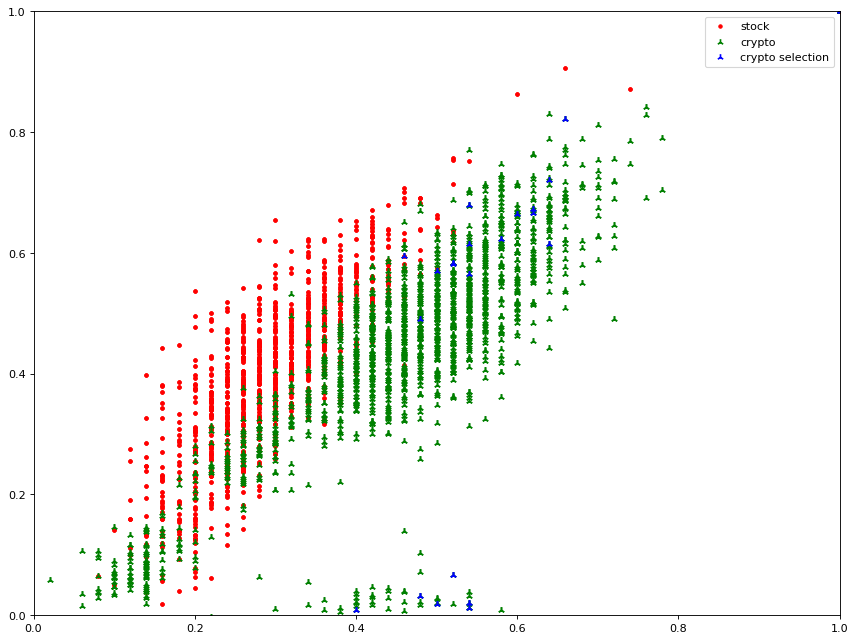

In [50]:
#@title 11.1.4
in_tail_stock = eta_stock < eta_stock.quantile(q=0.05)
probs_stock = pd.concat([in_tail_stock[in_tail_stock[col]==True].mean() 
                   for col in in_tail_stock], axis=1)
probs_stock.columns = probs_stock.index

in_tail_crypto = eta_crypto< eta_crypto.quantile(q=0.05)
probs_crypto= pd.concat([in_tail_crypto[in_tail_crypto[col]==True].mean()
                   for col in in_tail_crypto], axis=1)
probs_crypto.columns = probs_crypto.index

in_tail_crypto_selection = eta_crypto_selection< eta_crypto_selection.quantile(q=0.05)
probs_crypto_selection = pd.concat([in_tail_crypto_selection[in_tail_crypto_selection[col]==True].mean()
                   for col in in_tail_crypto_selection], axis=1)
probs_crypto_selection.columns = probs_crypto_selection.index

plt.figure(figsize=(13, 10), dpi=80)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(probs_stock.iloc[:,:], eta_stock.corr().iloc[:,:], marker=".", color="r", label="stock")
plt.scatter(probs_crypto.iloc[:,:], eta_crypto.corr().iloc[:,:], marker="2", color="g", label="crypto")
plt.scatter(probs_crypto_selection.iloc[:,:], eta_crypto_selection.corr().iloc[:,:], marker="2", color="b", label="crypto selection")

plt.legend()
plt.show()


#Variety and conditional statistics of the residuals

##The variety

On any given day, every stock of the S\&P 500 performs differently. The market return $\eta_{m}(t)$ is the average return over the population of stocks. A measure of the heterogeneity of the performance of the different stocks on a given day can be defined as the standard

$\dagger$ Note that $O_{i a}=v_{a, i}$ for $\mu=2$, as it should. deviation of the returns over the population of stocks, that we will call the variety $V(t)$ :

$$
\eta_{m}(t)=\frac{1}{M} \sum_{i=1}^{M} \eta_{i}(t) ; \quad V(t) = \sqrt{\frac{1}{M} \sum_{i=1}^{M}\left(\eta_{i}(t)-\eta_{m}(t)\right)^{2}}
$$

Suppose the market return is $\eta_{m}(t)=3 \%$. If the variety is, say, $0.1 \%$, then most stocks have indeed made between $2.9 \%$ and $3.1 \%$. But if the variety is $10 \%$, then stocks followed rather different trends during the day and their average happened to be positive. The variety is not the volatility of the index. The latter is a measure of the temporal fluctuations of the market return $\eta_{m}$, whereas the variety measures the instantaneous heterogeneity of stocks. Consider a day where the market has gone down $5 \%$ with a variety of $0.1 \%$ - that is, all stocks have gone down by nearly $5 \%$. This is a very volatile day, but with a low variety. Note that low variety means that it is hard to diversify: all stocks behave the same way.

The intuition is however that there should be a positive correlation between volatility and variety: when the market makes big swings, stocks are expected to be all over the place. This is indeed observed empirically: for example, the correlation coefficient between $V(t)$ and $\left|\eta_{m}\right|$, which is a simple proxy for the volatility, is $0.68$. A study of the temporal correlations of the variety shows a similar long-ranged dependence as the one discussed in details in the case of the volatility. More precisely, the variety variogram $\left\langle(V(t+\tau)-V(t))^{2}\right\rangle$ can also be fitted as an inverse power-law of $\tau$ with a small exponent, as in Section 7.2.2.

##The variety in the one-factor model

A theoretical relation between variety and market average return can be obtained within the framework of the one-factor model, that suggests that the variety increases when the market volatility increases. We assume that Eq. (11.3) holds with constant (in time) $\beta_{i}$ 's. In the standard one-factor model the distributions of $\eta_{m}$ and $\epsilon_{i}$ are chosen to be Gaussian with constant variances. We do not make this assumption here and let these distributions be completely general including possible volatility fluctuations.

In the study of the properties of the one-factor model it is useful to consider the variety $v(t)$ of the residuals, defined as

$$v^{2}(t)=\frac{1}{M} \sum_{i=1}^{M}\left[\epsilon_{i}(t)\right]^{2}$$

Under the above assumptions the relation between the variety and the market average return is well approximated by (see below):

$$V^{2}(t) \approx v^{2}(t)+\Delta \beta^{2} \eta_{m}^{2}(t)$$

where $\Delta \beta^{2}$ is the variance of the $\beta$ 's. If the number of stocks $M$ is large, then up to terms of order $1 / \sqrt{M}$, Eq. (11.26) indeed holds. Summing Eq. (11.3) over $i=1, \ldots, M$ one finds:

$$\eta_{m}(t)=\eta_{m}(t) \frac{1}{M} \sum_{i=1}^{M} \beta_{i}+\frac{1}{M} \sum_{i=1}^{M} \epsilon_{i}(t)$$

Since for a given day $t$ the idiosyncratic factors are uncorrelated from stock to stock, the second term on the right hand side is of order $1 / \sqrt{M}$, and can thus be neglected in a first approximation giving

$\bar{\beta}=1$,

where $\bar{\beta} \equiv \sum_{i=1}^{M} \beta_{i} /$. . Now square Eq. (11.3) and sum again over $i=1, \ldots$, M. This leads to:

$$
\frac{1}{M} \sum_{i=1}^{M} \eta_{i}^{2}(t)=\eta_{m}^{2}(t) \frac{1}{M} \sum_{i=1}^{M} \beta_{i}^{2}+\frac{1}{M} \sum_{i=1}^{M} \epsilon_{i}^{2}(t)+2 \eta_{m}(t) \frac{1}{M} \sum_{i=1}^{M} \beta_{i} \epsilon_{i}(t)
$$

Under the assumption that $\epsilon_{i}(t)$ and $\beta_{i}$ are uncorrelated the last term can be neglected and the variety $V(t)$, using (11.24), is given by Eq. (11.26).

Therefore, even if the idiosyncratic variety $v$ is constant, Eq. (11.26) predicts an increase of the variety with $\eta_{m}^{2}$, which is a proxy of the market volatility. Because $\Delta \beta^{2} \approx 0.05$ is small, however, the increase predicted by this simple model is too small to account for the empirical data. As we shall now discuss, the effect is enhanced by the fact that $v$ itself increases with the market volatility.

##Conditional variety of the residuals

In its simplest version, the one-factor model assumes that the idiosyncratic part $\epsilon_{i}$ is independent of the market return. In this case, the variety of idiosyncratic terms $v(t)$ is constant in time and independent from $\eta_{m}$. In Fig. (11.6), we show the variety of idiosyncratic terms as a function of the market return. In contrast with these predictions, the empirical results show that a significant correlation between $v(t)$ and $\eta_{m}(t)$ indeed exists. The degree of correlation is in fact different for positive and negative values of the market average. In fact, the best linear least-squares fit between $v(t)$ and $\eta_{m}(t)$ provides different slopes when the fit is performed for positive (slope $+0.55$ ) or negative (slope $-0.30$ ) value of the market average. Therefore, from Eq. (11.26) we find that the increase of variety in highly volatile periods is stronger than what is expected from the simplest one-factor model, although not as strong for negative (crashes) than it is for positive (rally) days.

The fact that the idiosyncratic variety $v(t)$ increases when the market return is large means that Eq. (11.4) grows less rapidly with $\left|\eta_{m}\right|$ than anticipated by the simplest one factor model. This allows one to understand qualitatively the effect shown in Fig. 11.1.

Hence, as anticipated in Section 9.2.4, one of the most serious drawback of linear correlation models such as the one-factor model is their inability to account for a common volatility factor. 

![](https://cdn.mathpix.com/cropped/2022_12_08_1b403185452beeedae75g-13.jpg?height=761&width=802&top_left_y=224&top_left_x=362)
<img src="https://cdn.mathpix.com/cropped/2022_12_08_1b403185452beeedae75g-13.jpg?height=761&width=802&top_left_y=224&top_left_x=362)" width="500"/>

<sub>Fig. 11.6. Daily variety $v$ of the residuals terms as a function of the market return $\eta_{m}$ of the 1071 NYSE stocks continuously traded from January 1987 to December 1998 . Each circle refers to one trading day of the investigated period. Main panel: trading days with $\eta_{m}$ belonging to the interval $[-0.05,0.05]$. Inset: the whole data set including five most extreme days. The two solid lines are linear fits over all days of positive (right line) and negative (left line) market average. The dotted lines are 'robust' linear fits. (Courtesy of F. Lillo and R. Mantegna.)<sub>


In [51]:
#@title 11.2 Variety
def variety(eta:pd.DataFrame) -> pd.DataFrame:
  """ Returns DataFrame with columns [average_return, variety] """
  eta_out = pd.DataFrame()
  eta_out["average_return"] = eta.mean(axis=1)
  eta_out["variety"] = eta.std(axis=1) #1/sqrt(M)
  eta_out["average_return"] = pd.Series(["{0:.2f}%".format(val * 100) for val in eta_out["average_return"]], index = eta_out.index)
  eta_out["variety"] = pd.Series(["{0:.2f}%".format(val * 100) for val in eta_out["variety"]], index = eta_out.index)  
  return eta_out 
variety(eta_stock) 

,average_return,variety
0,0.00%,0.00%
1,-0.32%,1.29%
2,-0.07%,1.84%
3,-0.07%,1.75%
4,-0.25%,0.76%
...,...,...
995,0.28%,1.12%
996,-1.00%,1.33%
997,0.14%,1.49%
998,-1.21%,1.23%


Text(0.5, 1.0, 'Crypto Selection')

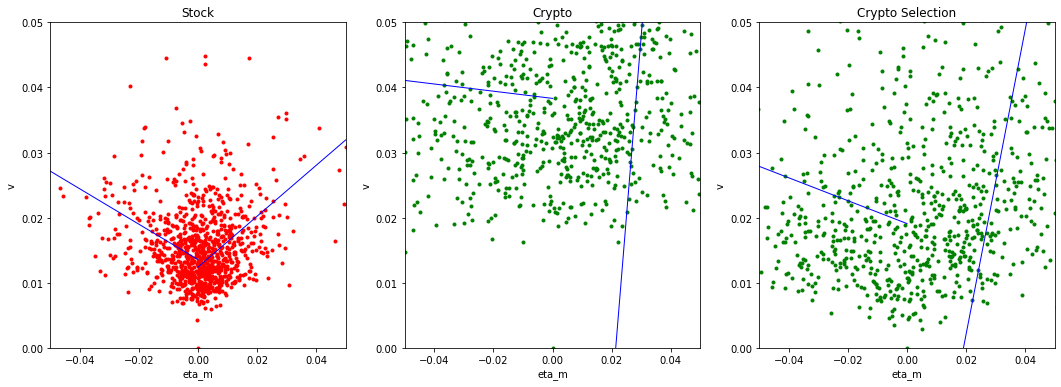

In [52]:
#@title 11.2.2 & 11.2.3
variety_stock = (1/ eps_stock.shape[1] * (eps_stock**2).sum(axis=1)).pow(1./2)
variety_crypto = (1/ eps_crypto.shape[1] * (eps_crypto**2).sum(axis=1)).pow(1./2)
variety_crypto_selection = (1/ eps_crypto_selection.shape[1] * (eps_crypto_selection**2).sum(axis=1)).pow(1./2)

eta_m_stock = eta_stock.mean(axis=1)
eta_m_crypto = eta_crypto.mean(axis=1) 
eta_m_crypto_selection = eta_crypto_selection.mean(axis=1) 

from sklearn.linear_model import LinearRegression

def reg_pos_neg(eta_m, variety):
  eta_m_pos = eta_m[eta_m >= 0].values
  eta_m_neg = eta_m[eta_m < 0].values
  variety_pos = variety[eta_m >= 0].values
  variety_neg = variety[eta_m < 0].values

  regr_pos = linear_model.LinearRegression(fit_intercept=True)
  regr_neg = linear_model.LinearRegression(fit_intercept=True)
  eta_m_pos = eta_m_pos.reshape(len(eta_m_pos), 1)
  eta_m_neg = eta_m_neg.reshape(len(eta_m_neg), 1)
  x_pos = variety_pos.reshape(len(variety_pos), 1)
  x_neg = variety_neg.reshape(len(variety_neg), 1)
  regr_pos.fit(eta_m_pos, x_pos)
  regr_neg.fit(eta_m_neg, x_neg)
  return regr_pos, regr_neg

ran_pos = np.linspace(0, 0.05, 20).reshape((20, 1))
ran_neg = np.linspace(0, -0.05, 20).reshape((20, 1))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
regr_pos, regr_neg = reg_pos_neg(eta_m_stock, variety_stock)
axes[0].scatter(eta_m_stock, variety_stock, marker=".", color="r")
axes[0].plot(ran_pos, regr_pos.predict(ran_pos), color='blue', linewidth=1)
axes[0].plot(ran_neg, regr_neg.predict(ran_neg), color='b', linewidth=1)
axes[0].set_xlim(-0.05, 0.05)
axes[0].set_ylim(0, 0.05)
axes[0].set_xlabel("eta_m")
axes[0].set_ylabel("v")
axes[0].set_title("Stock")

regr_pos, regr_neg = reg_pos_neg(eta_m_crypto, variety_crypto)
axes[1].scatter(eta_m_crypto, variety_crypto, marker=".", color="g")
axes[1].plot(ran_pos, regr_pos.predict(ran_pos), color='blue', linewidth=1)
axes[1].plot(ran_neg, regr_neg.predict(ran_neg), color='b', linewidth=1)
axes[1].set_xlim(-0.05, 0.05)
axes[1].set_ylim(0, 0.05)
axes[1].set_xlabel("eta_m")
axes[1].set_ylabel("v")
axes[1].set_title("Crypto")

regr_pos, regr_neg = reg_pos_neg(eta_m_crypto_selection, variety_crypto_selection)
axes[2].scatter(eta_m_crypto_selection, variety_crypto_selection, marker=".", color="g")
axes[2].plot(ran_pos, regr_pos.predict(ran_pos), color='blue', linewidth=1)
axes[2].plot(ran_neg, regr_neg.predict(ran_neg), color='b', linewidth=1)
axes[2].set_xlim(-0.05, 0.05)
axes[2].set_ylim(0, 0.05)
axes[2].set_xlabel("eta_m")
axes[2].set_ylabel("v")
axes[2].set_title("Crypto Selection")

##Conditional skewness of the residuals

Therefore, the idiosyncrasies are by construction uncorrelated, but not independent of the market. This shows up in the variety, does it also appear in different quantities? A natural question is: what fraction $f$ of stocks did actually better than the market? A balanced market would have $f=50 \%$. If $f$ is larger than $50 \%$, then the majority of the stocks beat the market, but a few ones lagging behind rather badly, and vice versa. A closely related measure is the asymmetry $A$, defined as $A(t)=\eta_{m}(t)-\eta^{*}(t)$, where the median $\eta^{*}$ is, by definition, the return such that $50 \%$ of the stocks are above, $50 \%$ below. If $f$ is larger than $50 \%$, then the median is larger than the average, and vice versa. Is the asymmetry $A$ also correlated with the market factor? Figure $11.7$ shows that it is indeed the case: large positive days show a positive skewness in the distribution of returns - that is, a few stocks do exceptionally well - whereas large negative days show the opposite behaviour. In the figure each day is represented by a circle and all the circles cluster in a pattern which has a sigmoidal shape. The asymmetrical behaviour observed during two extreme market events is shown in the insets of Figure 11.7. This empirical observation cannot be explained by a one-factor model, which predicts that $A$ is a constant. Intuitively, one possible explanation of this anomalous skewness (and a corresponding increase of variety) might be related to the existence of different sectors which strongly separate from each other during volatile days. 


<img src="https://cdn.mathpix.com/cropped/2022_12_08_1b403185452beeedae75g-14.jpg?height=774&width=1270&top_left_y=231&top_left_x=128" width="500"/>
<sub>Fig. 11.7. Daily asymmetry $\mathcal{A}$ of the probability density function of daily returns of a set of 1071 NYSE stocks continuously traded from January 1987 to December 1998 as a function of the market return $\eta_{m}$. Each circle refers to one trading day of the investigated period. Insets: the probability density function of daily returns observed for the two most extreme market days, both in October 1987. (Courtesy of F. Lillo and R. Mantegna).<sub>

Text(0.5, 1.0, 'Crypto')

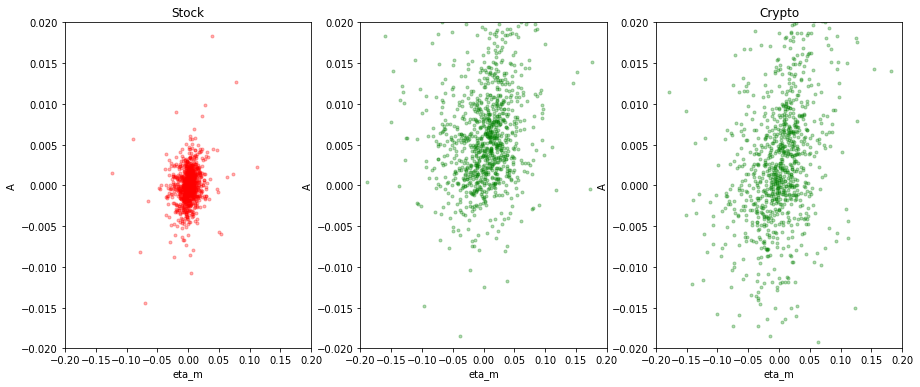

In [53]:
#@title 11.2.4 Conditional Skewness

eta_m_stock = eta_stock.mean(axis=1)
eta_m_crypto = eta_crypto.mean(axis=1)
eta_m_crypto_selection = eta_crypto_selection.mean(axis=1)

def asymmetry(eta:pd.DataFrame) -> pd.Series:
  eta_m = eta.mean(axis=1)
  eta_median = eta.median(axis=1)
  return eta_m - eta_median

#plt.scatter(eta_m_stock, asymmetry(eta_stock))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
axes[0].scatter(eta_m_stock, asymmetry(eta_stock),  marker=".", color="r", alpha=0.3)
axes[0].set_xlim(-0.2, 0.2)
axes[0].set_ylim(-0.02, 0.02)
axes[0].set_xlabel("eta_m")
axes[0].set_ylabel("A")
axes[0].set_title("Stock")
axes[1].scatter(eta_m_crypto, asymmetry(eta_crypto),  marker=".", color="g", alpha=0.3)
axes[1].set_xlim(-0.2, 0.2)
axes[1].set_ylim(-0.02, 0.02)
axes[1].set_xlabel("eta_m")
axes[1].set_ylabel("A")
axes[2].set_title("Crypto Selection")
axes[2].scatter(eta_m_crypto_selection, asymmetry(eta_crypto_selection),  marker=".", color="g", alpha=0.3)
axes[2].set_xlim(-0.2, 0.2)
axes[2].set_ylim(-0.02, 0.02)
axes[2].set_xlabel("eta_m")
axes[2].set_ylabel("A")
axes[2].set_title("Crypto")#asymmetry(eta_stock)

In [ ]:
#@title ...
#  eta_t_theta_av = 
#  #eta_t_theta1 = eta_tilde_[eta_tilde_ > theta].fillna(1) if theta > 0 else eta_tilde_[eta_tilde_ < theta].fillna(1)
#  #print(eta_t_theta)
#
#  rho_theta =  eta_t_theta.corr().to_numpy().mean()
#  return rho_theta#storage.mean()#rho_theta#storage.mean() #1-rho_thet
def positive_exceedance_correlation(i, j, theta):
  # Normalize the returns of i and j with zero mean and unit variance
  norm_i = (i - i.mean()) / i.std()
  norm_j = (j - j.mean()) / j.std()

  # Filter the normalized returns that are larger than theta
  if theta > 0:
    norm_i_filtered = norm_i[norm_i > theta]
    norm_j_filtered = norm_j[norm_j > theta]
  else:
    norm_i_filtered = norm_i[norm_i < theta]
    norm_j_filtered = norm_j[norm_j < theta]

  # Compute the average of the product of the filtered normalized returns
  avg_product = (norm_i_filtered * norm_j_filtered).mean()

  # Compute the average of the filtered first normalized return
  avg_i = norm_i_filtered.mean()

  # Compute the average of the filtered second normalized return
  avg_j = norm_j_filtered.mean()

  # Compute the average of the square of the filtered first normalized return
  avg_i_squared = (norm_i_filtered**2).mean()

  # Compute the average of the square of the filtered second normalized return
  avg_j_squared = (norm_j_filtered**2).mean()

  # Compute the numerator of the formula
  numerator = avg_product - avg_i * avg_j

  # Compute the denominator of the formula
  denominator = math.sqrt((avg_i_squared - avg_i**2) * (avg_j_squared - avg_j**2))

  # Compute and return the positive exceedance correlation
  return numerator / denominator

def rho(eta_tilde, theta):
  N = int(eta_tilde.shape[1])
  storage = np.zeros((N,N))
  for i, j in product(range(N), range(N)):
    eta_i = eta.iloc[:, i]
    eta_j = eta.iloc[:, j]
    rho_ij = positive_exceedance_correlation(eta_i, eta_j ,theta) 
    storage[i, j] = rho_ij
  return storage.mean()

rho(eta_stock, -1)

theta = np.linspace(-3, 3, 20)
rho_stock = [rho(eta_tilde_stock.iloc[:,:], t) for t in theta]
plt.figure(figsize=(10, 5), dpi=80)

#plt.plot(theta, rho_crypto, label="crypto")
#plt.plot(theta, rho_crypto_selection, label="crypto selection")
plt.plot(theta, rho_stock, label="stock")
plt.legend()
plt.show()

ef rho2(eta_tilde:pd.DataFrame, theta:float) -> float:
  eta_tilde_ = eta_tilde.copy()
  eta_t_theta = eta_tilde_[eta_tilde_ > theta].fillna(0) if theta > 0 else eta_tilde_[eta_tilde_ < theta].fillna(0)
  #nominator, denominator = 0, 0
  N = int(eta_tilde.shape[1])
  storage = np.zeros((N,N))
  for i, j in product(range(N), range(N)): 
    nominator = np.nan_to_num(filter_out_smaller_lambda(eta_tilde_.iloc[:,i]*eta_tilde_.iloc[:,j], theta).mean()) \
     - eta_t_theta.iloc[:,i].mean() \
     * eta_t_theta.iloc[:,j].mean()
    denominator = np.sqrt(
        abs(np.nan_to_num((filter_out_smaller_lambda(eta_tilde_.iloc[:, i]**2, theta).mean()) - np.nan_to_num(eta_t_theta.iloc[:,i].mean())**2) *\
        np.nan_to_num((filter_out_smaller_lambda(eta_tilde_.iloc[:, j]**2, theta).mean()) - np.nan_to_num(eta_t_theta.iloc[:,j].mean()**2)))
    )
    #print(denominator)
    storage[i,j] = nominator / denominator
  #rho_theta =  1 - eta_t_theta.corr().to_numpy().mean(
      
      def positive_exceedance_correlation(etai, etaj, theta):
    # Calculate the average of etai and etaj for values greater than theta
    mean_etai = np.mean(etai[etai > theta])
    mean_etaj = np.mean(etaj[etaj > theta])
    
    # Calculate the average of the product of etai and etaj for values greater than theta
    mean_etai_etaj = np.mean(etai[etai > theta] * etaj[etaj > theta])
    
    # Calculate the average of the square of etai for values greater than theta
    mean_etai_squared = np.mean(etai[etai > theta] ** 2)
    
    # Calculate the average of the square of etaj for values greater than theta
    mean_etaj_squared = np.mean(etaj[etaj > theta] ** 2)
    
    # Calculate the positive exceedance correlation
    rho = (mean_etai_etaj - mean_etai * mean_etaj) / np.sqrt((mean_etai_squared - mean_etai ** 2) * (mean_etaj_squared - mean_etaj ** 2))
    
    return rho
def positive_exceedance_correlation(eta_i, eta_j, theta):
    # Compute the average of eta_i and eta_j for values larger than theta
    avg_i = sum(eta_i[eta_i > theta]) / len(eta_i[eta_i > theta])
    avg_j = sum(eta_j[eta_j > theta]) / len(eta_j[eta_j > theta])
    
    # Compute the covariance and the variances of eta_i and eta_j for values larger than theta
    cov = sum((eta_i[eta_i > theta] - avg_i) * (eta_j[eta_j > theta] - avg_j)) / len(eta_i[eta_i > theta])
    var_i = sum((eta_i[eta_i > theta] - avg_i) ** 2) / len(eta_i[eta_i > theta])
    var_j = sum((eta_j[eta_j > theta] - avg_j) ** 2) / len(eta_j[eta_j > theta])
    
    # Compute and return the positive exceedance correlation
    return (cov - avg_i * avg_j) / math.sqrt(var_i * var_j)
def rho(eta_tilde:pd.DataFrame, theta:float) -> float:
    N = int(eta_tilde.shape[1])
    storage = np.zeros((N,N))
    for i, j in product(range(N), range(N)): 
      eta_tilde_i = eta_tilde.iloc[:, i]
      eta_tilde_j = eta_tilde.iloc[:, j]
      rho_ij = positive_exceedance_correlation(eta_tilde_i, eta_tilde_j, theta)
      storage[i, j] = rho_ij  
    return storage.mean()
      """
  N = int(eta_tilde.shape[1])
  storage = np.zeros((N,N))
  for i, j in product(range(N), range(N)): 
    eta_t_theta_i = eta_tilde_.iloc[:,i][eta_tilde_.iloc[:,i] > theta].dropna().to_numpy() if theta > 0 else eta_tilde_.iloc[:,i][eta_tilde_.iloc[:,i] < theta].dropna().to_numpy()
    eta_t_theta_j = eta_tilde_.iloc[:,j][eta_tilde_.iloc[:,j] > theta].dropna().to_numpy() if theta > 0 else eta_tilde_.iloc[:,j][eta_tilde_.iloc[:,i] < theta].dropna().to_numpy()
    K, L  = eta_t_theta_i.shape[0] ,eta_t_theta_j.shape[0] 
    avg = 0
    for k,l in product(range(K), range(L)):
      avg += eta_t_theta_i[k]*eta_t_theta_j[l]
    avg /= K*L
    nominator = avg \
     - eta_t_theta.iloc[:,i].mean() \
     * eta_t_theta.iloc[:,j].mean()
    denominator = np.sqrt(
        abs((eta_t_theta.iloc[:, i]**2).mean() - (eta_t_theta.iloc[:,i]).mean()**2 *\
        (eta_t_theta.iloc[:, j]**2).mean() - (eta_t_theta.iloc[:,j].mean())**2)
    )
    storage[i,j] = nominator / denominator"""
  #nominator, denominator = 0, 0
  """  N = int(eta_tilde.shape[1])
  storage = np.zeros((N,N))
  for i, j in product(range(N), range(N)): 
    nominator = (eta_t_theta1.iloc[:,i]*eta_t_theta1.iloc[:,j]).mean() \
     - eta_t_theta.iloc[:,i].mean() \
     * eta_t_theta.iloc[:,j].mean()
    denominator = np.sqrt(
        abs((eta_t_theta.iloc[:, i]**2).mean() - (eta_t_theta.iloc[:,i]).mean()**2 *\
        (eta_t_theta.iloc[:, j]**2).mean() - (eta_t_theta.iloc[:,j].mean())**2)
    )
    storage[i,j] = nominator / denominator"""
rho(eta_tilde_stock, 1)

def positive_exceedance_correlation(etai, etaj, theta):
    # Calculate the average of etai and etaj for values greater than theta
    mean_etai = np.mean(etai[etai > theta])
    mean_etaj = np.mean(etaj[etaj > theta])
    
    # Calculate the average of the product of etai and etaj for values greater than theta
    mean_etai_etaj = np.mean(etai[etai > theta] * etaj[etaj > theta])
    
    # Calculate the average of the square of etai for values greater than theta
    mean_etai_squared = np.mean(etai[etai > theta] ** 2)
    
    # Calculate the average of the square of etaj for values greater than theta
    mean_etaj_squared = np.mean(etaj[etaj > theta] ** 2)
    
    # Calculate the positive exceedance correlation
    rho = (mean_etai_etaj - mean_etai * mean_etaj) / np.sqrt((mean_etai_squared - mean_etai ** 2) * (mean_etaj_squared - mean_etaj ** 2))
    
    return rho
def positive_exceedance_correlation(eta_i, eta_j, theta):
    # Compute the average of eta_i and eta_j for values larger than theta
    avg_i = sum(eta_i[eta_i > theta]) / len(eta_i[eta_i > theta])
    avg_j = sum(eta_j[eta_j > theta]) / len(eta_j[eta_j > theta])
    
    # Compute the covariance and the variances of eta_i and eta_j for values larger than theta
    cov = sum((eta_i[eta_i > theta] - avg_i) * (eta_j[eta_j > theta] - avg_j)) / len(eta_i[eta_i > theta])
    var_i = sum((eta_i[eta_i > theta] - avg_i) ** 2) / len(eta_i[eta_i > theta])
    var_j = sum((eta_j[eta_j > theta] - avg_j) ** 2) / len(eta_j[eta_j > theta])
    
    # Compute and return the positive exceedance correlation
    return (cov - avg_i * avg_j) / math.sqrt(var_i * var_j)
def rho(eta_tilde:pd.DataFrame, theta:float) -> float:
    N = int(eta_tilde.shape[1])
    storage = np.zeros((N,N))
    for i, j in product(range(N), range(N)): 
      eta_tilde_i = eta_tilde.iloc[:, i]
      eta_tilde_j = eta_tilde.iloc[:, j]
      rho_ij = positive_exceedance_correlation(eta_tilde_i, eta_tilde_j, theta)
      storage[i, j] = rho_ij  
    return storage.mean()
      """
  N = int(eta_tilde.shape[1])
  storage = np.zeros((N,N))
  for i, j in product(range(N), range(N)): 
    eta_t_theta_i = eta_tilde_.iloc[:,i][eta_tilde_.iloc[:,i] > theta].dropna().to_numpy() if theta > 0 else eta_tilde_.iloc[:,i][eta_tilde_.iloc[:,i] < theta].dropna().to_numpy()
    eta_t_theta_j = eta_tilde_.iloc[:,j][eta_tilde_.iloc[:,j] > theta].dropna().to_numpy() if theta > 0 else eta_tilde_.iloc[:,j][eta_tilde_.iloc[:,i] < theta].dropna().to_numpy()
    K, L  = eta_t_theta_i.shape[0] ,eta_t_theta_j.shape[0] 
    avg = 0
    for k,l in product(range(K), range(L)):
      avg += eta_t_theta_i[k]*eta_t_theta_j[l]
    avg /= K*L
    nominator = avg \
     - eta_t_theta.iloc[:,i].mean() \
     * eta_t_theta.iloc[:,j].mean()
    denominator = np.sqrt(
        abs((eta_t_theta.iloc[:, i]**2).mean() - (eta_t_theta.iloc[:,i]).mean()**2 *\
        (eta_t_theta.iloc[:, j]**2).mean() - (eta_t_theta.iloc[:,j].mean())**2)
    )
    storage[i,j] = nominator / denominator"""
  #nominator, denominator = 0, 0
  """  N = int(eta_tilde.shape[1])
  storage = np.zeros((N,N))
  for i, j in product(range(N), range(N)): 
    nominator = (eta_t_theta1.iloc[:,i]*eta_t_theta1.iloc[:,j]).mean() \
     - eta_t_theta.iloc[:,i].mean() \
     * eta_t_theta.iloc[:,j].mean()
    denominator = np.sqrt(
        abs((eta_t_theta.iloc[:, i]**2).mean() - (eta_t_theta.iloc[:,i]).mean()**2 *\
        (eta_t_theta.iloc[:, j]**2).mean() - (eta_t_theta.iloc[:,j].mean())**2)
    )
    storage[i,j] = nominator / denominator"""
rho(eta_tilde_stock, 1)

#eta = 1- stat.ratio #-1
#eta = 1 - ratio(stat.X)
#eta.plot()
#eta.corr()
eta=eta_stock.iloc[:1000, :]
scaler.fit(eta)
eta_tilde = scaler.transform(eta)
eta_tilde = pd.DataFrame(eta_tilde)
corr = eta_tilde.corr()
theta = 8
eta_t_theta = eta_tilde[eta_tilde > theta].fillna(0)
#eta_t_theta 
rho_theta = eta_t_theta.corr()
#print(rho_theta.mean().mean())

def rho(theta:float) -> float:

  eta_t_theta = eta_tilde[eta_tilde > theta].fillna(0) if theta > 0 else eta_tilde[eta_tilde < theta].fillna(0)
  rho_theta = 1-eta_t_theta.corr()
  return rho_theta.to_numpy().mean()
theta = np.linspace(-3, 3, 50)
vals = [rho(thet) for thet in theta]
plt.plot(theta, vals)